In [2]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import torch.nn.functional as F

#plotting
import matplotlib.pyplot as plt

import data_utils
import models
import importlib
import transformer_models
importlib.reload(data_utils)
importlib.reload(models)
importlib.reload(transformer_models)
from data_utils import *
from models import *
from transformer_models import * 
import torch.optim as optim
from torch.utils.data import DataLoader
import datetime
from tqdm import tqdm 
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
data_dir = "data/"
dataObject = xrdData("data/", device)

dataObject.make_datasets(1, composition_embedding="compositionseq")
# Create DataLoaders for train and validation sets
train_loader = DataLoader(dataObject.torch_datasets['train'], batch_size=32, shuffle=True)
valid_loader = DataLoader(dataObject.torch_datasets['val'], batch_size=32, shuffle=False)  

In [13]:
output_dim = 230  # Output dimension
ConvModel = XRD_C_SymNet(in_channels=1, output_dim=output_dim, composition_model= None).to(device)
token_size = 10 #dimension of the tokens 
TransModel = TransformerModel(ntoken = output_dim, d_model = token_size, nhead = 10, d_hid=50, nlayers=1, dropout = 0.5).to(device)
model = TransModel

weight_decay = 1e-3 
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

/vast/palmer/home.mccleary/cpsc452_ijo4/.local/share/virtualenvs/cpsc452_ijo4-QeZ8YQJ2/lib64/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


12160
torch.Size([40, 80])
torch.Size([80, 40])


In [14]:
max_epochs = 100
metrics = ["accuracy", "loss"]

In [15]:
pickle_path = 'wo_comp_eval_results.pkl'

# load existing data from pickle file
def load_data(pickle_path):
    try:
        with open(pickle_path, 'rb') as f:
            return pickle.load(f)
    except (EOFError, FileNotFoundError):
        return []  

# save data to a pickle file
def save_data(data, pickle_path):
    with open(pickle_path, 'wb') as f:
        pickle.dump(data, f)


In [16]:
USE_COMPOSITION = False

In [17]:
crop_starts_stops = [300, 500, 700, 900, 1100]  
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
drop_freqs = [2, 4, 8, 16, 32] 

log = load_data(pickle_path)

# Training loop with noise level variation
for i in range(4,5):
    crop_start = crop_starts_stops[i]
    crop_stop = crop_starts_stops[i] 
    noise_level = noise_levels[i]
    drop_freq = drop_freqs[i]
    
    print(f"Run {i+1}: Crop Start/Stop: {crop_start}, Noise Level: {noise_level}, Drop Frequency: {drop_freq}")
    run_data = {'run': i+1, 'parameters': {'crop_start': crop_start, 'noise_level': noise_level, 'drop_freq': drop_freq}, 'epochs': []}
   
    simulator = ExperimentalSimulation(device, crop_start=crop_start, crop_stop=crop_stop, noise_range=noise_level, drop_width=100, drop_freq=drop_freq)

    for epoch in range(max_epochs):
        model.train()  
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for xrd, composition, targets in tqdm(train_loader):
            xrd = simulator.sim(xrd)
            optimizer.zero_grad()
            if not USE_COMPOSITION: 
                composition = None
            outputs = model(xrd, composition)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        train_accuracy = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()  
        total_valid_loss = 0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():  
            for xrd, composition, targets in tqdm(valid_loader):
                xrd = simulator.sim(xrd)
                if not USE_COMPOSITION: 
                    composition = None
                outputs = model(xrd, composition)
                loss = criterion(outputs, targets)
                total_valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1) 
                total_valid += targets.size(0)
                correct_valid += (predicted == targets).sum().item()

        valid_accuracy = 100 * correct_valid / total_valid

        total_train_loss = total_train_loss / len(train_loader)
        validation_loss = total_valid_loss / len(valid_loader)

        print(f"Epoch {epoch+1}, Training Loss: {total_train_loss}, Training Accuracy: {train_accuracy}%, Validation Loss: {validation_loss}, Validation Accuracy: {valid_accuracy}%")
        run_data['epochs'].append({
        'epoch': epoch,
        'type': 'Train',
        'train_accuracy': train_accuracy,
        'train_loss': total_train_loss
        })
        run_data['epochs'].append({
            'epoch': epoch,
            'type': 'Validation',
            'valid_accuracy': valid_accuracy,
            'valid_loss': validation_loss
        })
    log.append(run_data)
    
save_data(log, pickle_path)


Run 5: Crop Start/Stop: 1100, Noise Level: 0.5, Drop Frequency: 32


100%|██████████| 121/121 [00:02<00:00, 48.55it/s]


Epoch 1, Training Loss: 4.374284346151003, Training Accuracy: 12.209150326797385%, Validation Loss: 4.844153821960954, Validation Accuracy: 12.843086483687209%


100%|██████████| 121/121 [00:02<00:00, 45.83it/s]


Epoch 2, Training Loss: 4.035270891219471, Training Accuracy: 12.816993464052288%, Validation Loss: 4.674054394083575, Validation Accuracy: 12.843086483687209%


100%|██████████| 121/121 [00:02<00:00, 47.59it/s]


Epoch 3, Training Loss: 4.026450421244622, Training Accuracy: 12.92156862745098%, Validation Loss: 4.538386092698278, Validation Accuracy: 12.843086483687209%


100%|██████████| 121/121 [00:02<00:00, 48.19it/s]


Epoch 4, Training Loss: 4.003258247235975, Training Accuracy: 12.937908496732026%, Validation Loss: 4.33798701704041, Validation Accuracy: 12.972553081305023%


100%|██████████| 121/121 [00:02<00:00, 48.90it/s]


Epoch 5, Training Loss: 3.9702881630685263, Training Accuracy: 13.290849673202615%, Validation Loss: 4.143113918540892, Validation Accuracy: 13.90471258415329%


100%|██████████| 121/121 [00:02<00:00, 47.23it/s]


Epoch 6, Training Loss: 3.921814400075994, Training Accuracy: 14.062091503267974%, Validation Loss: 4.02560253773839, Validation Accuracy: 15.06991196271362%


100%|██████████| 121/121 [00:02<00:00, 46.62it/s]


Epoch 7, Training Loss: 3.865244361175888, Training Accuracy: 14.892156862745098%, Validation Loss: 3.9482900899303845, Validation Accuracy: 14.836872087001554%


100%|██████████| 121/121 [00:02<00:00, 46.03it/s]


Epoch 8, Training Loss: 3.8056763710771357, Training Accuracy: 15.764705882352942%, Validation Loss: 3.872705067484832, Validation Accuracy: 13.283272915587778%


100%|██████████| 121/121 [00:02<00:00, 46.44it/s]


Epoch 9, Training Loss: 3.7740058383224153, Training Accuracy: 15.947712418300654%, Validation Loss: 3.7808720592624887, Validation Accuracy: 15.121698601760746%


100%|██████████| 121/121 [00:02<00:00, 44.75it/s]


Epoch 10, Training Loss: 3.742519508459476, Training Accuracy: 16.49346405228758%, Validation Loss: 3.755990136753429, Validation Accuracy: 15.14759192128431%


100%|██████████| 121/121 [00:02<00:00, 46.46it/s]


Epoch 11, Training Loss: 3.7210770094282575, Training Accuracy: 16.395424836601308%, Validation Loss: 3.7316079139709473, Validation Accuracy: 16.079751424132574%


100%|██████████| 121/121 [00:02<00:00, 46.89it/s]


Epoch 12, Training Loss: 3.7030548145031106, Training Accuracy: 16.69607843137255%, Validation Loss: 3.7158237863178094, Validation Accuracy: 16.545831175556707%


100%|██████████| 121/121 [00:02<00:00, 46.56it/s]


Epoch 13, Training Loss: 3.690674336352692, Training Accuracy: 16.99019607843137%, Validation Loss: 3.695136336255665, Validation Accuracy: 16.545831175556707%


100%|██████████| 121/121 [00:02<00:00, 47.90it/s]


Epoch 14, Training Loss: 3.678792239979392, Training Accuracy: 17.130718954248366%, Validation Loss: 3.658762216567993, Validation Accuracy: 17.944070429829104%


100%|██████████| 121/121 [00:02<00:00, 45.89it/s]


Epoch 15, Training Loss: 3.663967961926196, Training Accuracy: 17.4281045751634%, Validation Loss: 3.641724417032289, Validation Accuracy: 17.45209735888141%


100%|██████████| 121/121 [00:02<00:00, 44.75it/s]


Epoch 16, Training Loss: 3.6478283719209292, Training Accuracy: 17.398692810457515%, Validation Loss: 3.616103601849769, Validation Accuracy: 18.72087001553599%


100%|██████████| 121/121 [00:02<00:00, 46.14it/s]


Epoch 17, Training Loss: 3.6375295241424657, Training Accuracy: 17.601307189542485%, Validation Loss: 3.5999843896913135, Validation Accuracy: 18.461936820300362%


100%|██████████| 121/121 [00:02<00:00, 47.72it/s]


Epoch 18, Training Loss: 3.634006470099263, Training Accuracy: 17.68300653594771%, Validation Loss: 3.5903820124539463, Validation Accuracy: 18.61729673744174%


100%|██████████| 121/121 [00:02<00:00, 45.03it/s]


Epoch 19, Training Loss: 3.6161171403424492, Training Accuracy: 18.107843137254903%, Validation Loss: 3.5674766883377202, Validation Accuracy: 18.72087001553599%


100%|██████████| 121/121 [00:02<00:00, 48.82it/s]


Epoch 20, Training Loss: 3.602328628581893, Training Accuracy: 17.81045751633987%, Validation Loss: 3.5582633373165917, Validation Accuracy: 18.824443293630242%


100%|██████████| 121/121 [00:02<00:00, 48.89it/s]


Epoch 21, Training Loss: 3.596514798007913, Training Accuracy: 17.862745098039216%, Validation Loss: 3.5461301508028646, Validation Accuracy: 18.772656654583116%


100%|██████████| 121/121 [00:02<00:00, 47.86it/s]


Epoch 22, Training Loss: 3.5860331673856316, Training Accuracy: 18.186274509803923%, Validation Loss: 3.541508777082459, Validation Accuracy: 18.87622993267737%


100%|██████████| 121/121 [00:02<00:00, 48.80it/s]


Epoch 23, Training Loss: 3.5710098050853927, Training Accuracy: 18.415032679738562%, Validation Loss: 3.5379230345576262, Validation Accuracy: 18.746763335059555%


100%|██████████| 121/121 [00:02<00:00, 48.23it/s]


Epoch 24, Training Loss: 3.553026147521526, Training Accuracy: 18.748366013071895%, Validation Loss: 3.528623267638782, Validation Accuracy: 19.65302951838426%


100%|██████████| 121/121 [00:02<00:00, 48.88it/s]


Epoch 25, Training Loss: 3.5433233691108885, Training Accuracy: 18.892156862745097%, Validation Loss: 3.524991224619968, Validation Accuracy: 19.368203003625066%


100%|██████████| 121/121 [00:02<00:00, 48.32it/s]


Epoch 26, Training Loss: 3.5309364417005358, Training Accuracy: 18.901960784313726%, Validation Loss: 3.5427312259831703, Validation Accuracy: 19.135163127913%


100%|██████████| 121/121 [00:02<00:00, 48.19it/s]


Epoch 27, Training Loss: 3.5206602967520366, Training Accuracy: 19.07843137254902%, Validation Loss: 3.535487281389473, Validation Accuracy: 19.05748316934231%


100%|██████████| 121/121 [00:02<00:00, 48.21it/s]


Epoch 28, Training Loss: 3.4909443758124468, Training Accuracy: 19.630718954248366%, Validation Loss: 3.5386749082360387, Validation Accuracy: 18.850336613153807%


100%|██████████| 121/121 [00:02<00:00, 48.80it/s]


Epoch 29, Training Loss: 3.487607266337396, Training Accuracy: 19.741830065359476%, Validation Loss: 3.540434267895281, Validation Accuracy: 19.186949766960126%


100%|██████████| 121/121 [00:02<00:00, 47.82it/s]


Epoch 30, Training Loss: 3.4745527108510337, Training Accuracy: 20.11437908496732%, Validation Loss: 3.540052362709991, Validation Accuracy: 19.109269808389435%


100%|██████████| 121/121 [00:02<00:00, 48.84it/s]


Epoch 31, Training Loss: 3.467952609685023, Training Accuracy: 20.104575163398692%, Validation Loss: 3.518681526184082, Validation Accuracy: 19.186949766960126%


100%|██████████| 121/121 [00:02<00:00, 48.39it/s]


Epoch 32, Training Loss: 3.458170492447282, Training Accuracy: 20.15359477124183%, Validation Loss: 3.5292641269273997, Validation Accuracy: 19.394096323148627%


100%|██████████| 121/121 [00:02<00:00, 48.22it/s]


Epoch 33, Training Loss: 3.4431114747357343, Training Accuracy: 20.61437908496732%, Validation Loss: 3.507727152059886, Validation Accuracy: 19.005696530295182%


100%|██████████| 121/121 [00:02<00:00, 48.07it/s]


Epoch 34, Training Loss: 3.4257298709207693, Training Accuracy: 20.69607843137255%, Validation Loss: 3.5460188940536876, Validation Accuracy: 19.67892283790782%


100%|██████████| 121/121 [00:02<00:00, 45.87it/s]


Epoch 35, Training Loss: 3.421464841816742, Training Accuracy: 20.754901960784313%, Validation Loss: 3.5198656330423908, Validation Accuracy: 20.352149145520457%


100%|██████████| 121/121 [00:02<00:00, 46.49it/s]


Epoch 36, Training Loss: 3.4043111559490176, Training Accuracy: 21.258169934640524%, Validation Loss: 3.5082208775291757, Validation Accuracy: 19.730709476954946%


100%|██████████| 121/121 [00:02<00:00, 48.20it/s]


Epoch 37, Training Loss: 3.3921541265808552, Training Accuracy: 21.101307189542485%, Validation Loss: 3.4871349610573006, Validation Accuracy: 20.015535991714138%


100%|██████████| 121/121 [00:02<00:00, 48.19it/s]


Epoch 38, Training Loss: 3.3898881974015986, Training Accuracy: 21.313725490196077%, Validation Loss: 3.46601597139658, Validation Accuracy: 20.11910926980839%


100%|██████████| 121/121 [00:02<00:00, 48.19it/s]


Epoch 39, Training Loss: 3.3828537421789537, Training Accuracy: 21.529411764705884%, Validation Loss: 3.4698355867842996, Validation Accuracy: 20.378042465044018%


100%|██████████| 121/121 [00:02<00:00, 48.09it/s]


Epoch 40, Training Loss: 3.367249425800367, Training Accuracy: 21.676470588235293%, Validation Loss: 3.4726262230518437, Validation Accuracy: 19.782496116002072%


100%|██████████| 121/121 [00:02<00:00, 46.62it/s]


Epoch 41, Training Loss: 3.3621630352243486, Training Accuracy: 21.84313725490196%, Validation Loss: 3.4352871583512994, Validation Accuracy: 21.36198860693941%


100%|██████████| 121/121 [00:02<00:00, 48.14it/s]


Epoch 42, Training Loss: 3.3627558362396783, Training Accuracy: 21.784313725490197%, Validation Loss: 3.4540255522925007, Validation Accuracy: 20.067322630761264%


100%|██████████| 121/121 [00:02<00:00, 45.00it/s]


Epoch 43, Training Loss: 3.3450592002649415, Training Accuracy: 21.96732026143791%, Validation Loss: 3.443512175693985, Validation Accuracy: 21.387881926462974%


100%|██████████| 121/121 [00:02<00:00, 48.16it/s]


Epoch 44, Training Loss: 3.3375321794826784, Training Accuracy: 21.95751633986928%, Validation Loss: 3.4226005964042727, Validation Accuracy: 20.766442257897463%


100%|██████████| 121/121 [00:02<00:00, 48.17it/s]


Epoch 45, Training Loss: 3.330472125030486, Training Accuracy: 22.454248366013072%, Validation Loss: 3.431597940192735, Validation Accuracy: 21.36198860693941%


100%|██████████| 121/121 [00:02<00:00, 48.21it/s]


Epoch 46, Training Loss: 3.321062263151944, Training Accuracy: 22.555555555555557%, Validation Loss: 3.4037212951124207, Validation Accuracy: 21.28430864836872%


100%|██████████| 121/121 [00:02<00:00, 46.29it/s]


Epoch 47, Training Loss: 3.3161462529201367, Training Accuracy: 22.718954248366014%, Validation Loss: 3.3662998144291647, Validation Accuracy: 22.061108234075608%


100%|██████████| 121/121 [00:02<00:00, 44.87it/s]


Epoch 48, Training Loss: 3.3101614430904887, Training Accuracy: 22.96732026143791%, Validation Loss: 3.3943559965811487, Validation Accuracy: 21.413775245986535%


100%|██████████| 121/121 [00:02<00:00, 46.38it/s]


Epoch 49, Training Loss: 3.3053501409672146, Training Accuracy: 22.980392156862745%, Validation Loss: 3.3655989820306953, Validation Accuracy: 22.68254790264112%


100%|██████████| 121/121 [00:02<00:00, 48.15it/s]


Epoch 50, Training Loss: 3.3057993751334545, Training Accuracy: 22.947712418300654%, Validation Loss: 3.3861479286319955, Validation Accuracy: 21.957534955981355%


100%|██████████| 121/121 [00:02<00:00, 48.56it/s]


Epoch 51, Training Loss: 3.2955532196048907, Training Accuracy: 23.215686274509803%, Validation Loss: 3.3376310699242207, Validation Accuracy: 22.941481097876746%


100%|██████████| 121/121 [00:02<00:00, 46.20it/s]


Epoch 52, Training Loss: 3.2795711866615957, Training Accuracy: 23.12091503267974%, Validation Loss: 3.337112659265187, Validation Accuracy: 22.553081305023305%


100%|██████████| 121/121 [00:02<00:00, 46.09it/s]


Epoch 53, Training Loss: 3.282846386280678, Training Accuracy: 23.454248366013072%, Validation Loss: 3.3473449817373733, Validation Accuracy: 22.889694458829624%


100%|██████████| 121/121 [00:02<00:00, 45.14it/s]


Epoch 54, Training Loss: 3.2700853327847823, Training Accuracy: 23.54901960784314%, Validation Loss: 3.337230788774727, Validation Accuracy: 22.630761263593993%


100%|██████████| 121/121 [00:02<00:00, 46.45it/s]


Epoch 55, Training Loss: 3.26282146756801, Training Accuracy: 23.754901960784313%, Validation Loss: 3.324359322382399, Validation Accuracy: 22.96737441740031%


100%|██████████| 121/121 [00:02<00:00, 48.09it/s]


Epoch 56, Training Loss: 3.2536099066679505, Training Accuracy: 23.924836601307188%, Validation Loss: 3.295647652681209, Validation Accuracy: 23.48524080787157%


100%|██████████| 121/121 [00:02<00:00, 48.94it/s]


Epoch 57, Training Loss: 3.250818194515902, Training Accuracy: 24.04248366013072%, Validation Loss: 3.3036566174719946, Validation Accuracy: 22.78612118073537%


100%|██████████| 121/121 [00:02<00:00, 44.76it/s]


Epoch 58, Training Loss: 3.2524951219309584, Training Accuracy: 23.705882352941178%, Validation Loss: 3.2880273909608193, Validation Accuracy: 23.48524080787157%


100%|██████████| 121/121 [00:02<00:00, 46.26it/s]


Epoch 59, Training Loss: 3.235438196138404, Training Accuracy: 24.480392156862745%, Validation Loss: 3.2983089971148276, Validation Accuracy: 23.12273433454169%


100%|██████████| 121/121 [00:02<00:00, 46.05it/s]


Epoch 60, Training Loss: 3.233227463226956, Training Accuracy: 24.473856209150327%, Validation Loss: 3.2729127485890035, Validation Accuracy: 23.84774728120145%


100%|██████████| 121/121 [00:02<00:00, 48.08it/s]


Epoch 61, Training Loss: 3.2288389970765468, Training Accuracy: 24.169934640522875%, Validation Loss: 3.2744420087041934, Validation Accuracy: 23.744174003107197%


100%|██████████| 121/121 [00:02<00:00, 48.52it/s]


Epoch 62, Training Loss: 3.2178048985380614, Training Accuracy: 24.519607843137255%, Validation Loss: 3.2528205568140205, Validation Accuracy: 24.21025375453133%


100%|██████████| 121/121 [00:02<00:00, 46.03it/s]


Epoch 63, Training Loss: 3.216845245072336, Training Accuracy: 24.50980392156863%, Validation Loss: 3.260339264042121, Validation Accuracy: 24.443293630243396%


100%|██████████| 121/121 [00:02<00:00, 48.48it/s]


Epoch 64, Training Loss: 3.211416668279044, Training Accuracy: 24.477124183006534%, Validation Loss: 3.245780846304145, Validation Accuracy: 23.873640600725015%


100%|██████████| 121/121 [00:02<00:00, 45.70it/s]


Epoch 65, Training Loss: 3.199782776857494, Training Accuracy: 24.72875816993464%, Validation Loss: 3.2503160307230043, Validation Accuracy: 24.46918694976696%


100%|██████████| 121/121 [00:02<00:00, 48.77it/s]


Epoch 66, Training Loss: 3.194631160488946, Training Accuracy: 24.836601307189543%, Validation Loss: 3.220296227242336, Validation Accuracy: 24.961160020714654%


100%|██████████| 121/121 [00:02<00:00, 48.29it/s]


Epoch 67, Training Loss: 3.1997262646785725, Training Accuracy: 24.830065359477125%, Validation Loss: 3.2290318780694127, Validation Accuracy: 24.443293630243396%


100%|██████████| 121/121 [00:02<00:00, 48.48it/s]


Epoch 68, Training Loss: 3.189990382209467, Training Accuracy: 25.11111111111111%, Validation Loss: 3.22378668509239, Validation Accuracy: 25.038839979285346%


100%|██████████| 121/121 [00:02<00:00, 48.08it/s]


Epoch 69, Training Loss: 3.1929100175138054, Training Accuracy: 24.758169934640524%, Validation Loss: 3.208952560897701, Validation Accuracy: 24.417400310719835%


100%|██████████| 121/121 [00:02<00:00, 45.97it/s]


Epoch 70, Training Loss: 3.1847578113978434, Training Accuracy: 25.320261437908496%, Validation Loss: 3.17678885617532, Validation Accuracy: 25.504919730709478%


100%|██████████| 121/121 [00:02<00:00, 46.40it/s]


Epoch 71, Training Loss: 3.176089074046136, Training Accuracy: 25.415032679738562%, Validation Loss: 3.2391272418755146, Validation Accuracy: 24.36561367167271%


100%|██████████| 121/121 [00:02<00:00, 48.93it/s]


Epoch 72, Training Loss: 3.173056125640869, Training Accuracy: 25.26797385620915%, Validation Loss: 3.176793459033178, Validation Accuracy: 25.504919730709478%


100%|██████████| 121/121 [00:02<00:00, 48.52it/s]


Epoch 73, Training Loss: 3.1614181541973023, Training Accuracy: 25.591503267973856%, Validation Loss: 3.1855326585533206, Validation Accuracy: 25.37545313309166%


100%|██████████| 121/121 [00:02<00:00, 46.34it/s]


Epoch 74, Training Loss: 3.163230749008673, Training Accuracy: 25.568627450980394%, Validation Loss: 3.156762040351048, Validation Accuracy: 25.97099948213361%


100%|██████████| 121/121 [00:02<00:00, 48.79it/s]


Epoch 75, Training Loss: 3.1628264436652045, Training Accuracy: 25.607843137254903%, Validation Loss: 3.1668656502873445, Validation Accuracy: 25.99689280165717%


100%|██████████| 121/121 [00:02<00:00, 46.75it/s]


Epoch 76, Training Loss: 3.1658316547967797, Training Accuracy: 25.640522875816995%, Validation Loss: 3.145572392408513, Validation Accuracy: 26.540652511651995%


100%|██████████| 121/121 [00:02<00:00, 46.24it/s]


Epoch 77, Training Loss: 3.1518992508217583, Training Accuracy: 25.88235294117647%, Validation Loss: 3.1518510392874726, Validation Accuracy: 25.556706369756604%


100%|██████████| 121/121 [00:02<00:00, 45.47it/s]


Epoch 78, Training Loss: 3.1564491789169073, Training Accuracy: 25.529411764705884%, Validation Loss: 3.152816740934514, Validation Accuracy: 25.97099948213361%


100%|██████████| 121/121 [00:02<00:00, 46.41it/s]


Epoch 79, Training Loss: 3.1382322271540373, Training Accuracy: 25.627450980392158%, Validation Loss: 3.1394653576464693, Validation Accuracy: 25.763852925945105%


100%|██████████| 121/121 [00:02<00:00, 48.16it/s]


Epoch 80, Training Loss: 3.1337361682046794, Training Accuracy: 25.941176470588236%, Validation Loss: 3.145001636063757, Validation Accuracy: 26.074572760227863%


100%|██████████| 121/121 [00:02<00:00, 46.45it/s]


Epoch 81, Training Loss: 3.1336908303084416, Training Accuracy: 26.163398692810457%, Validation Loss: 3.1362436684695156, Validation Accuracy: 27.265665458311755%


100%|██████████| 121/121 [00:02<00:00, 45.91it/s]


Epoch 82, Training Loss: 3.1287493371913673, Training Accuracy: 25.954248366013072%, Validation Loss: 3.142315551269153, Validation Accuracy: 25.945106162610045%


100%|██████████| 121/121 [00:02<00:00, 44.78it/s]


Epoch 83, Training Loss: 3.125867655035595, Training Accuracy: 26.22222222222222%, Validation Loss: 3.1084213847956383, Validation Accuracy: 26.462972553081304%


100%|██████████| 121/121 [00:02<00:00, 48.37it/s]


Epoch 84, Training Loss: 3.1260084221480158, Training Accuracy: 26.225490196078432%, Validation Loss: 3.102229031649503, Validation Accuracy: 27.6540652511652%


100%|██████████| 121/121 [00:02<00:00, 48.39it/s]


Epoch 85, Training Loss: 3.1269309438508133, Training Accuracy: 26.00653594771242%, Validation Loss: 3.089555578783524, Validation Accuracy: 27.446918694976695%


100%|██████████| 121/121 [00:02<00:00, 46.10it/s]


Epoch 86, Training Loss: 3.1253305348483, Training Accuracy: 26.41176470588235%, Validation Loss: 3.113232135772705, Validation Accuracy: 26.618332470222683%


100%|██████████| 121/121 [00:02<00:00, 46.06it/s]


Epoch 87, Training Loss: 3.102673116522523, Training Accuracy: 26.57843137254902%, Validation Loss: 3.1231485083083474, Validation Accuracy: 26.721905748316935%


100%|██████████| 121/121 [00:02<00:00, 44.42it/s]


Epoch 88, Training Loss: 3.109938416984263, Training Accuracy: 26.598039215686274%, Validation Loss: 3.1054591620263974, Validation Accuracy: 26.540652511651995%


100%|██████████| 121/121 [00:02<00:00, 48.37it/s]


Epoch 89, Training Loss: 3.1040496091234773, Training Accuracy: 26.568627450980394%, Validation Loss: 3.0956638647505073, Validation Accuracy: 28.068358363542206%


100%|██████████| 121/121 [00:02<00:00, 44.69it/s]


Epoch 90, Training Loss: 3.1031432139337873, Training Accuracy: 26.676470588235293%, Validation Loss: 3.099629293788563, Validation Accuracy: 27.187985499741067%


100%|██████████| 121/121 [00:02<00:00, 45.93it/s]


Epoch 91, Training Loss: 3.0904199872769285, Training Accuracy: 26.977124183006534%, Validation Loss: 3.090095216577703, Validation Accuracy: 27.006732263076128%


100%|██████████| 121/121 [00:02<00:00, 47.71it/s]


Epoch 92, Training Loss: 3.08678506260257, Training Accuracy: 26.80392156862745%, Validation Loss: 3.074494978613105, Validation Accuracy: 27.705851890212326%


100%|██████████| 121/121 [00:02<00:00, 45.75it/s]


Epoch 93, Training Loss: 3.0887092395511417, Training Accuracy: 27.058823529411764%, Validation Loss: 3.125212145245765, Validation Accuracy: 26.462972553081304%


100%|██████████| 121/121 [00:02<00:00, 46.01it/s]


Epoch 94, Training Loss: 3.0852738587709307, Training Accuracy: 26.980392156862745%, Validation Loss: 3.1002069051600687, Validation Accuracy: 26.721905748316935%


100%|██████████| 121/121 [00:02<00:00, 44.72it/s]


Epoch 95, Training Loss: 3.0864072523645225, Training Accuracy: 26.908496732026144%, Validation Loss: 3.0928853523632713, Validation Accuracy: 27.628171931641635%


100%|██████████| 121/121 [00:02<00:00, 48.71it/s]


Epoch 96, Training Loss: 3.0753822819939973, Training Accuracy: 27.22222222222222%, Validation Loss: 3.090311842516434, Validation Accuracy: 27.8612118073537%


100%|██████████| 121/121 [00:02<00:00, 45.72it/s]


Epoch 97, Training Loss: 3.070161212574352, Training Accuracy: 27.218954248366014%, Validation Loss: 3.0991674986752598, Validation Accuracy: 26.721905748316935%


100%|██████████| 121/121 [00:02<00:00, 44.80it/s]


Epoch 98, Training Loss: 3.0697744271349134, Training Accuracy: 27.50980392156863%, Validation Loss: 3.049295311131753, Validation Accuracy: 28.3531848783014%


100%|██████████| 121/121 [00:02<00:00, 45.98it/s]


Epoch 99, Training Loss: 3.081328202938211, Training Accuracy: 26.9281045751634%, Validation Loss: 3.070283673026345, Validation Accuracy: 27.084412221646815%


100%|██████████| 121/121 [00:02<00:00, 48.30it/s]

Epoch 100, Training Loss: 3.060783105833279, Training Accuracy: 27.483660130718953%, Validation Loss: 3.0724279072659075, Validation Accuracy: 27.731745209735887%


In [19]:
data = load_data(pickle_path)
len(data)

5

In [20]:
import pandas as pd

rows = []
for run in data:  
    for epoch in run['epochs']: 
        row = {
            'run': run['run'],
            'type': epoch['type'],
            'crop_start': run['parameters']['crop_start'],
            'noise_level': run['parameters']['noise_level'],
            'drop_freq': run['parameters']['drop_freq'],
            'epoch': epoch['epoch'],
            
        }
        if epoch['type'] == 'Train':
            row.update({
                'accuracy': epoch.get('train_accuracy'),
                'loss': epoch.get('train_loss')
            })
        elif epoch['type'] == 'Validation':
            row.update({
                'accuracy': epoch.get('valid_accuracy'),
                'loss': epoch.get('valid_loss')
            })
        rows.append(row)
df = pd.DataFrame(rows) 
df

,run,type,crop_start,noise_level,drop_freq,epoch,accuracy,loss
0,1,Train,300,0.1,2,0,12.892157,4.265243
1,1,Validation,300,0.1,2,0,14.267219,3.981019
2,1,Train,300,0.1,2,1,17.196078,3.714029
3,1,Validation,300,0.1,2,1,18.306577,3.777469
4,1,Train,300,0.1,2,2,20.843137,3.476478
...,...,...,...,...,...,...,...,...
995,5,Validation,1100,0.5,32,97,28.353185,3.049295
996,5,Train,1100,0.5,32,98,26.928105,3.081328
997,5,Validation,1100,0.5,32,98,27.084412,3.070284
998,5,Train,1100,0.5,32,99,27.483660,3.060783


Text(0.5, 1.0, 'Training and Validation Loss')

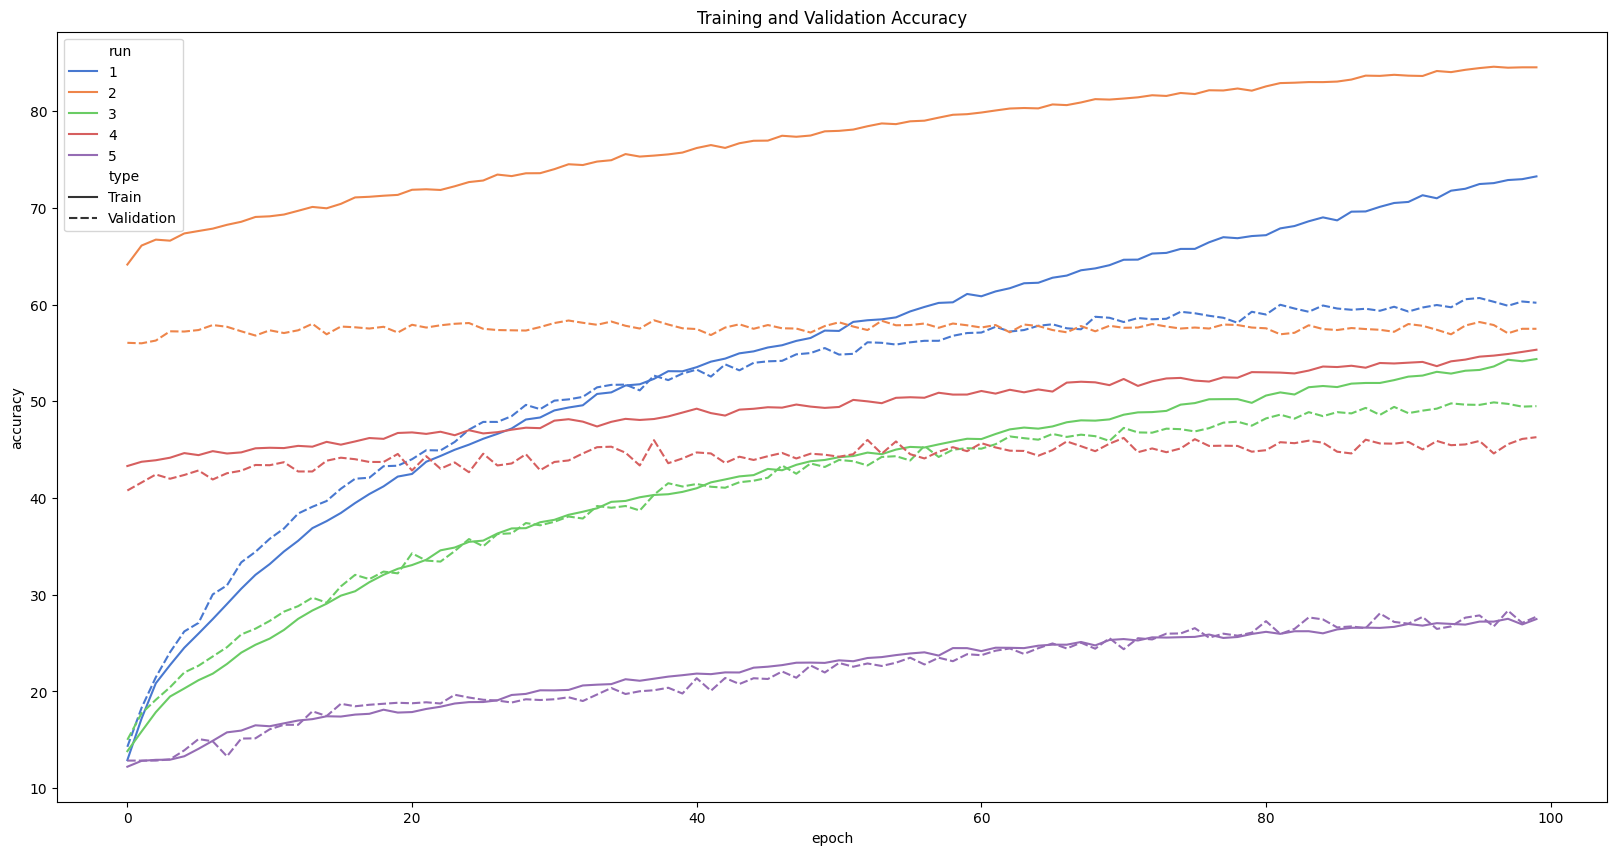

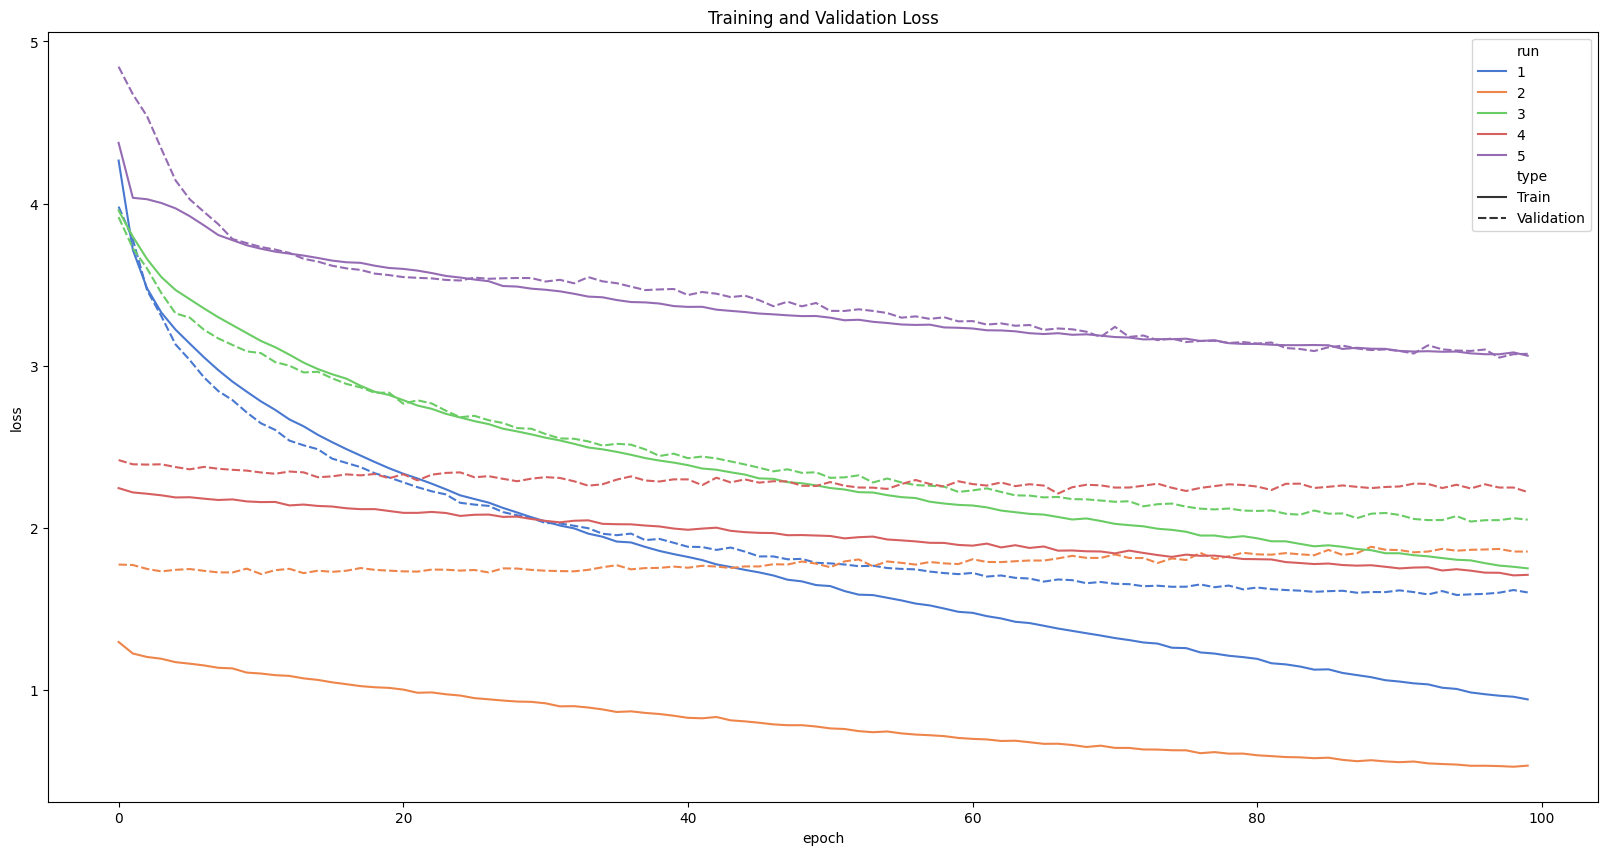

In [21]:
import seaborn as sns

# plot training and validation accuracy
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='epoch', y='accuracy', hue='run', style='type', palette='muted')
plt.title('Training and Validation Accuracy')

# plot training and validation loss
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='epoch', y='loss', hue='run', style='type', palette='muted')
plt.title('Training and Validation Loss')
